# Installation to run the code in this notebook (requirement file)

In [1]:
# pip install pandas numpy
# pip install ftfy
# pip install cleantext
# pip install bertopic
# pip install ipywidgets
# pip install matplotlib seaborn

# Importing libraries

In [2]:
# Data and number processing
import pandas as pd 
import numpy as np 

#  fix mojibake errors
from ftfy import fix_encoding

# Topic generation and text processing
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Imporing modules
import os
import sys

# Add the src path to sys.path
sys.path.append(os.path.abspath('../src'))
from modules.modules import (missing_values_calculator_and_shape, text_cleaning_process)

# Data Preprocessing (EDA - Data exploratory analysis and Data Cleaning)

In [3]:
pd.set_option('display.max_rows', None)
df = pd.read_csv('../data/Dataset - EMPOLITICON NLP and ML Based Approach for Context and Emotion Classification of Political Speeches From Transcripts.csv')
df.iloc[:5]

,Country,Date,Speaker,Headline,Text_of_Speech,Designation,Running President/PM,Speech Link,Emotion,Context
0,Russia,16/07/2021,Vladimir Putin,Meeting of APEC Economic Leaders,"Madam Chair,\n\nColleagues,\n\nFirst of all, ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,OPTIMISM,DEVELOPMENT
1,Russia,2021-09-05 00:00:00,Vladimir Putin,Victory Parade on Red Square,"Citizens of Russia,\n\nDear veterans,\n\nComra...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,JOY,NATIONALISM
2,Russia,2021-08-04 00:00:00,Vladimir Putin,Meeting on the results of implementing Preside...,"Good afternoon, colleagues.\n\nLet’s start.\n\...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,NEUTRAL,DEVELOPMENT
3,Russia,21-11-2020,Vladimir Putin,G20 Summit,"Colleagues,\n\nThe scope of problems humanity ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,NEUTRAL,DEVELOPMENT
4,Russia,20-11-2020,Vladimir Putin,Address to participants in Nuremberg Lessons f...,"Colleagues, friends,\n\nFirst of all, I would ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,UPSET,EXTREMISM


# Checking NaN values

In [4]:
missing_values_calculator_and_shape(df)

,NAMES,NULL VALUE COUNT,NULL VALUES IN PERCENTAGES (%),DATA TYPE
0,Country,0,0.0,object
1,Date,0,0.0,object
2,Speaker,0,0.0,object
3,Headline,0,0.0,object
4,Text_of_Speech,0,0.0,object
5,Designation,0,0.0,object
6,Running President/PM,0,0.0,object
7,Speech Link,0,0.0,object
8,Emotion,0,0.0,object
9,Context,0,0.0,object


For the moment and for simplicity, only the Russian analysis would be taken into account. In the future, the other parties, will be taken into account. Also, just for future analysis, I will turn the Date column into an actual date format (current one in Object format).

To do that, I will use the `pd.to_datetime()` function from the pandas library to convert the 'Date' column into a datetime format. This will allow for easier manipulation and analysis of the date data. Furthermore, I will manualy remove time from the date, as it is not needed for the analysis.

## Fixing the date format

In [5]:
# df.loc[:, 'Date'] = pd.to_datetime(df['Date'], 
#                                    errors='coerce',
#                                    dayfirst=True)
# df.iloc[:5]

## Filtering to get only the Russian section

In [6]:
russian_df = df[df['Country'] == 'Russia'].reset_index(drop = True)
# russian_df.iloc[:5]
# russian_df.tail(5)

Let us compress the dataset to the speech only so we can analyse it and extract the topic from scratch

In [7]:
r_df = russian_df[['Date', 'Text_of_Speech']]
r_df.iloc[:5]

,Date,Text_of_Speech
0,16/07/2021,"Madam Chair,\n\nColleagues,\n\nFirst of all, ..."
1,2021-09-05 00:00:00,"Citizens of Russia,\n\nDear veterans,\n\nComra..."
2,2021-08-04 00:00:00,"Good afternoon, colleagues.\n\nLet’s start.\n\..."
3,21-11-2020,"Colleagues,\n\nThe scope of problems humanity ..."
4,20-11-2020,"Colleagues, friends,\n\nFirst of all, I would ..."


## Fixing mojibake errors (character-encoding errors)

In [8]:
r_df.loc[:, 'Text_of_Speech'] = r_df['Text_of_Speech'].apply(
    lambda x: fix_encoding(x) if isinstance(x, str) else x)
r_df.iloc[:5]

,Date,Text_of_Speech
0,16/07/2021,"Madam Chair,\n\nColleagues,\n\nFirst of all, ..."
1,2021-09-05 00:00:00,"Citizens of Russia,\n\nDear veterans,\n\nComra..."
2,2021-08-04 00:00:00,"Good afternoon, colleagues.\n\nLet’s start.\n\..."
3,21-11-2020,"Colleagues,\n\nThe scope of problems humanity ..."
4,20-11-2020,"Colleagues, friends,\n\nFirst of all, I would ..."


## Cleaning special characters, punctuation, and numbers

In [9]:
r_df.loc[:, 'Text_of_Speech'] = r_df['Text_of_Speech'].apply(text_cleaning_process)
r_df.iloc[:5]

,Date,Text_of_Speech
0,16/07/2021,madam chair\n\ncolleagues\n\nfirst of all i wo...
1,2021-09-05 00:00:00,citizens of russia\n\ndear veterans\n\ncomrade...
2,2021-08-04 00:00:00,good afternoon colleagues\n\nlet’s start\n\nas...
3,21-11-2020,colleagues\n\nthe scope of problems humanity h...
4,20-11-2020,colleagues friends\n\nfirst of all i would lik...


# Topic Generation

***To add to the README file:***  

As written in the BERTopic’s documentation (make it a link - 'how to deal with topic outliers' https://maartengr.github.io/BERTopic/faq.html#how-do-i-reduce-topic-outliers ): Removing stop words as a preprocessing step is not advised as the transformer-based embedding models that we use need the full context to create accurate embeddings.

We use ```CountVectorizer``` in this case, only for the Bigram (and Trigram models in future improvements), as it is more suitable for these types of models. The ```CountVectorizer``` will be used to create a vocabulary of words that will be used to generate the topics. However, we will not use it to remove stop words, as it is not advised to do so. Instead, we will use the ```BERTopic``` model in combination with ```SentenceTransformer``` to generate the topics.

```BERTopic``` uses sentence transformer models as its first building block, converting sentences into dense vector representations (i.e. embeddings) that capture semantic meanings. These models are based on transformer architectures like BERT and are specifically trained to produce high-quality sentence embeddings. We then compute the semantic similarity between sentences using cosine distance between the embeddings. Common models include:

- ***all-MiniLM-L6-v2:*** lightweight, fast, good general performance
- ***BAAI/bge-base-en-v1.5:*** larger model with strong semantic understanding hence gives much slower training and inference speed.
There are a massive range of pre-trained sentence transformers for you to choose from on the “Sentence Transformer - https://www.sbert.net/docs/sentence_transformer/pretrained_models.html” website and 'Huggingface model hub - https://huggingface.co/models'. 

```Bertopic``` has a built-in parameter called ```n_gram_range``` to define the n-gram as well. Nevertheless, by using the `CountVectorizer` we can define the n-gram range more precisely and have more control (customization options) when fine-tuning the model. The `ngram_range` parameter in `CountVectorizer` allows us to specify the range of n-grams to be extracted from the text data. This is particularly useful for capturing phrases or combinations of words that may carry significant meaning in the context of the topics being analyzed.

# For the n-Gram, Here is an clarification:

## 📚 Understanding `ngram_range=(X, Y)` in `CountVectorizer`

The `ngram_range` parameter controls **how many words the model looks at together** when converting text into tokens.

> 🧠 It does **not** split text into “word + what follows.” Instead, it defines the **size of grouped word sequences (n-grams)**.

---

### 💡 Breakdown

| n-gram type | What it extracts                | Example (from `"climate change policy"`)            |
|-------------|----------------------------------|-----------------------------------------------------|
| `(1, 1)`    | Unigrams (single words)          | `"climate"`, `"change"`, `"policy"`                |
| `(2, 2)`    | Bigrams (2-word phrases)         | `"climate change"`, `"change policy"`              |
| `(3, 3)`    | Trigrams (3-word phrases)        | `"climate change policy"`                          |
| `(1, 3)`    | All n-grams from 1 to 3 words    | `"climate"`, `"climate change"`, `"climate change policy"` |

---

### ✅ Summary

- **The first number** in the range = minimum number of words per phrase.
- **The second number** = maximum number of words per phrase.
- This is about **grouping neighbouring words**, not predicting what comes next.

In [15]:
# Create a list of speeches
docs = r_df['Text_of_Speech'].tolist()

# Define vectorizer (For the Bigram model - pair of words)
vectorizer_model = CountVectorizer(ngram_range = (2, 2))

# Number of topics to be generated
n_topics = 7

# VERSION WITH A PRETRAINED MODEL (to fine-tune the model, we can test other pre-models)

# emb_minilm = SentenceTransformer("all-MiniLM-L6-v2") # This is a smaller model that is faster and requires less memory

# # Build BERTopic model
# topic_model = BERTopic(
#     top_n_words         = 10,
#     n_gram_range        = (2,2),
#     nr_topics           = n_topics,
#     embedding_model     = emb_minilm,
#     vectorizer_model    = vectorizer_model,
#     umap_model          = UMAP(random_state = 1)
# )

# VERSION WITH A COUNTVECTORIZER

# Remove english stopwords with a vectorizer
standard_stopwords = list(stopwords.words('english'))

# # Test 1
additional_stopwords = ['let', 'us','like','say','would','also',
                        'th','need','afternoon','ladies','gentleman',
                        'foremost','colleagues','friends','years',
                        'ago','last','year']

# # Test 2
# additional_stopwords = [
#     'people', 'government', 'country', 'nation', 'state', 'public', 'citizen',
#     'citizens', 'parliament', 'house', 'chamber', 'minister', 'leaders',
#     'leader', 'party', 'parties', 'political', 'politics', 'policy', 'policies',
#     'economy', 'economic', 'social', 'national', 'international', 'global',
#     'community', 'communities', 'system', 'systems', 'reform', 'future',
#     'today', 'tomorrow', 'yesterday', 'time', 'years', 'year', 'day', 'days',
#     'new', 'old', 'great', 'good', 'bad', 'well', 'better', 'best', 'more',
#     'less', 'much', 'many', 'all', 'any', 'some', 'no', 'every', 'each',
#     'these', 'those', 'this', 'that', 'here', 'there', 'now', 'then', 'also',
#     'just', 'only', 'very', 'really', 'even', 'indeed', 'however', 'therefore',
#     'furthermore', 'moreover', 'thus', 'so', 'and', 'but', 'or', 'if', 'because',
#     'as', 'while', 'when', 'where', 'how', 'what', 'which', 'who', 'whom',
#     'whose', 'why', 'we', 'us', 'our', 'ours', 'they', 'them', 'their', 'theirs',
#     'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'you', 'your', 'yours',
#     'i', 'me', 'my', 'mine', 'myself', 'ourselves', 'themselves', 'himself',
#     'herself', 'itself', 'can', 'will', 'would', 'should', 'could', 'may', 'might',
#     'must', 'have', 'has', 'had', 'do', 'does', 'did', 'being', 'been', 'is', 'am',
#     'are', 'was', 'were', 'from', 'with', 'about', 'across', 'after', 'against',
#     'along', 'among', 'around', 'at', 'before', 'behind', 'below', 'beneath',
#     'beside', 'between', 'beyond', 'by', 'down', 'during', 'except', 'for', 'from',
#     'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'out',
#     'outside', 'over', 'past', 'round', 'through', 'to', 'toward', 'towards',
#     'under', 'underneath', 'until', 'up', 'upon', 'with', 'within', 'without',
#     'about', 'above', 'below', 'across', 'already', 'always', 'another', 'anywhere',
#     'around', 'become', 'becomes', 'certain', 'clearly', 'come', 'comes', 'consider',
#     'considering', 'continue', 'continues', 'definitely', 'despite', 'develop',
#     'developed', 'developing', 'different', 'doing', 'done', 'during', 'effect',
#     'effective', 'effectively', 'either', 'else', 'ensure', 'ensuring', 'example',
#     'examples', 'experience', 'experiences', 'fact', 'facts', 'feel', 'feeling',
#     'finally', 'first', 'follow', 'following', 'force', 'forces', 'found',
#     'general', 'generally', 'give', 'given', 'goes', 'going', 'gone', 'growth',
#     'happens', 'high', 'hold', 'holds', 'home', 'hope', 'important', 'include',
#     'includes', 'including', 'increase', 'increased', 'indeed', 'inside',
#     'instead', 'interest', 'into', 'issue', 'issues', 'keep', 'keeps', 'known',
#     'large', 'larger', 'least', 'left', 'level', 'levels', 'life', 'little',
#     'long', 'look', 'looks', 'made', 'make', 'makes', 'making', 'means', 'member',
#     'members', 'moment', 'most', 'name', 'need', 'needs', 'never', 'next', 'once',
#     'order', 'part', 'particularly', 'place', 'places', 'point', 'points', 'power',
#     'present', 'presented', 'problem', 'problems', 'process', 'processes',
#     'provide', 'provided', 'provides', 'rather', 'reach', 'reaches', 'reason',
#     'reasons', 'recent', 'recently', 'represent', 'represents', 'require',
#     'requires', 'rest', 'right', 'run', 'runs', 'say', 'says', 'second', 'see',
#     'seem', 'seems', 'seen', 'sense', 'set', 'sets', 'should', 'show', 'shows',
#     'side', 'since', 'small', 'solution', 'solutions', 'something', 'sometimes',
#     'start', 'starts', 'still', 'strong', 'sure', 'take', 'takes', 'telling',
#     'terms', 'thank', 'thanks', 'think', 'thinking', 'thought', 'thoughts',
#     'through', 'told', 'total', 'towards', 'true', 'truth', 'try', 'trying',
#     'type', 'types', 'understand', 'understanding', 'unit', 'units', 'until',
#     'use', 'used', 'uses', 'usually', 'value', 'values', 'various', 'want',
#     'wants', 'way', 'ways', 'whether', 'whole', 'why', 'wide', 'wish', 'word',
#     'words', 'work', 'works', 'world', 'would', 'yet', 'across', 'along', 'around',
#     'away', 'back', 'come', 'down', 'forward', 'in', 'off', 'on', 'out', 'over',
#     'round', 'through', 'up', 'well', 'whatsoever'
# ]

full_stopwords = standard_stopwords + additional_stopwords

vectorizer_model = CountVectorizer(ngram_range  = (2, 2),
                                   stop_words   = full_stopwords)

# Generate a bigram topic model with 10 top terms and 8 topics
topic_model = BERTopic(top_n_words          = 10,
                          n_gram_range      = (2,2),
                          nr_topics         = n_topics,
                          vectorizer_model  = vectorizer_model,
                          umap_model        = UMAP(random_state=1))  # setting seed topics re


# Fit model
topics, probabilities = topic_model.fit_transform(docs)

Note that the ```nr_topics``` is set to 7 for generating 6 topics. The remaining topic is used to keep the outliers.

On the other hand, after generating topics and their probabilities, we can access the frequent topics that were generated:

In [16]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,156,-1_russian federation_prosecutors office_secur...,"[russian federation, prosecutors office, secur...",[dear colleagues\n\nwe are meeting in this unu...
1,0,212,0_state duma_russian federation_united russia_...,"[state duma, russian federation, united russia...",[good afternoon colleagues\n\ndear friends\n\n...
2,1,92,1_law enforcement_interior ministry_enforcemen...,"[law enforcement, interior ministry, enforceme...",[dear colleagues\n\ntoday’s coordination meeti...
3,2,39,2_patriotic war_great patriotic_world war_vict...,"[patriotic war, great patriotic, world war, vi...",[people of russia\n\nour dear veterans\n\nfore...
4,3,33,3_armed forces_defence ministry_security counc...,"[armed forces, defence ministry, security coun...",[good afternoon colleagues\n\nduring the board...
5,4,13,4_russian orthodox_orthodox church_religious a...,"[russian orthodox, orthodox church, religious ...",[your holiness\n\nparticipants in the meeting\...
6,5,12,5_higher education_education system_quality ed...,"[higher education, education system, quality e...",[good afternoon\n\ntoday’s presidium is meetin...


-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [17]:
topic_model.get_topic(0)

[('state duma', np.float64(0.0058282229054049395)),
 ('russian federation', np.float64(0.004769306071448602)),
 ('united russia', np.float64(0.0040322226803891845)),
 ('far east', np.float64(0.003909919855655464)),
 ('foreign policy', np.float64(0.0033931551373459277)),
 ('economic growth', np.float64(0.0032967775220564925)),
 ('economic development', np.float64(0.0030497217405539927)),
 ('national projects', np.float64(0.002872422329089863)),
 ('state council', np.float64(0.0026047476585926176)),
 ('business community', np.float64(0.0023288758952432955))]

# Topic visualization

By extracting bigrams and their probabilities from the topic model, the creation of a focused data frame is possible for each of the 6 topics. After that, a heatmap can be generated to visualize the distribution of bigrams across the topics. This visualization will help in understanding the most significant bigrams associated with each topic and their relative importance.

```----"the `pyLDAvis` library can be used to visualize the topics and their relationships. This visualization will help in understanding the distribution of topics and their significance in the context of the speeches."```

In [18]:
# Pending to make it a FOR LOOP

# Create a DataFrame for each topic with words and their probabilities
topic_1 = pd.DataFrame(topic_model.get_topic(0), columns=["Topic_1_word", "Topic_1_prob"])
topic_2 = pd.DataFrame(topic_model.get_topic(1), columns=["Topic_2_word", "Topic_2_prob"])
topic_3 = pd.DataFrame(topic_model.get_topic(2), columns=["Topic_3_word", "Topic_3_prob"])
topic_4 = pd.DataFrame(topic_model.get_topic(3), columns=["Topic_4_word", "Topic_4_prob"])
topic_5 = pd.DataFrame(topic_model.get_topic(4), columns=["Topic_5_word", "Topic_5_prob"])
topic_6 = pd.DataFrame(topic_model.get_topic(5), columns=["Topic_6_word", "Topic_6_prob"])

# Concatenate all topic DataFrames into a single DataFrame
topics_df = pd.concat([topic_1, 
                       topic_2, 
                       topic_3, 
                       topic_4, 
                       topic_5, 
                       topic_6], axis=1)

Visualizing the topics with a heatmap can provide insights into the distribution of bigrams across different topics. This can help in understanding which bigrams are more prevalent in certain topics and how they relate to each other.

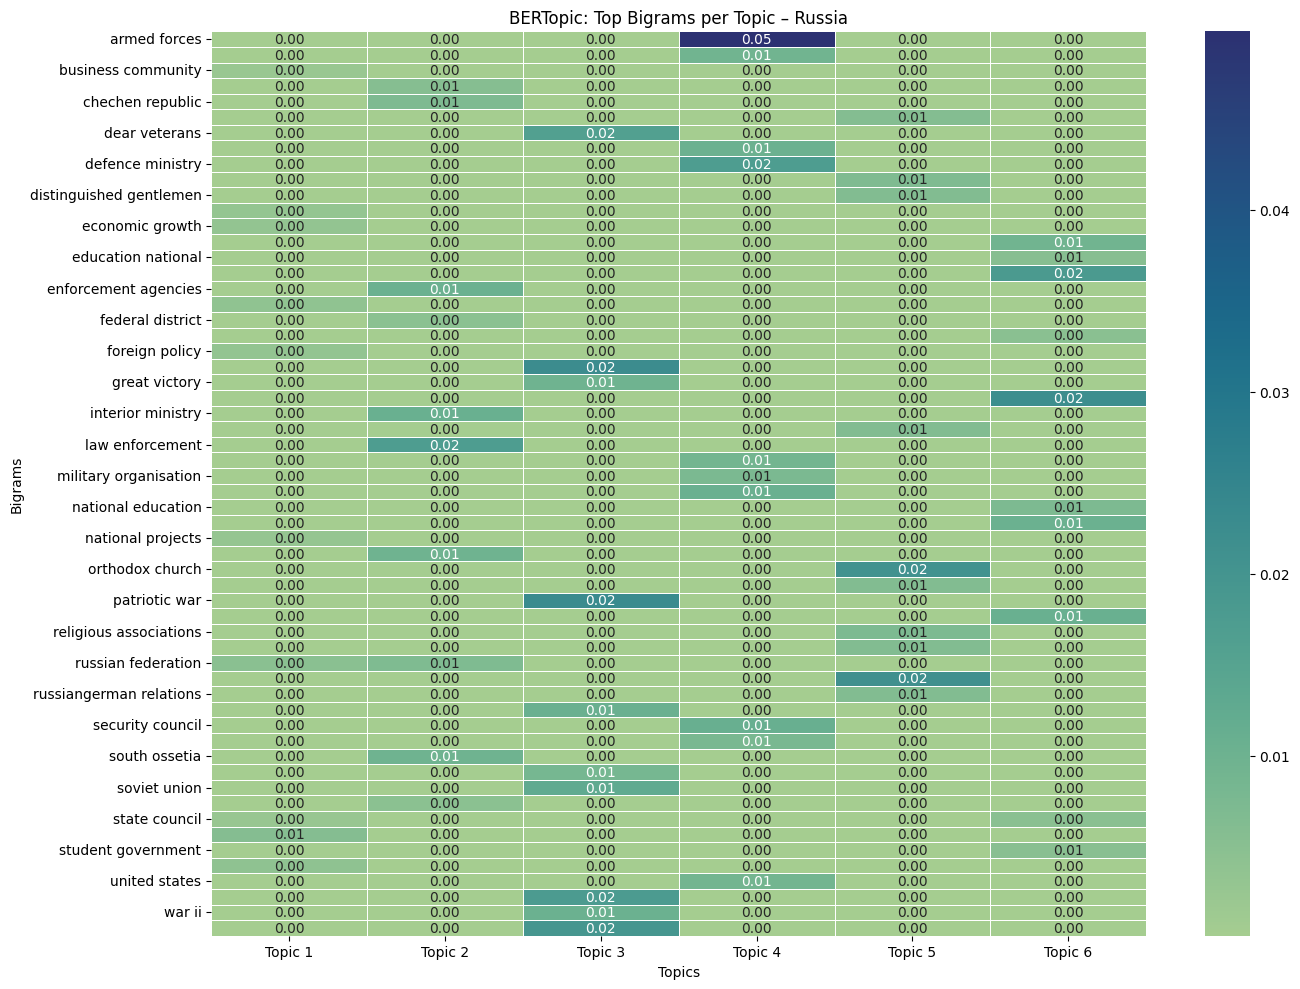

In [19]:
# Combine topics into one DataFrame
topics = []
for i in range(1, 7):
    words = topics_df[f"Topic_{i}_word"]
    probs = topics_df[f"Topic_{i}_prob"]
    temp_df = pd.DataFrame({
        'Bigram': words,
        'Topic': f'Topic {i}',
        'Prob': probs
    })
    topics.append(temp_df)

reshaped_data = pd.concat(topics)

# Pivot table: Bigram as rows, Topics as columns
pivot_table = reshaped_data.pivot(index='Bigram', columns='Topic', values='Prob').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 10))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(pivot_table, cmap=cmap, linewidths=0.5, annot=True, fmt=".2f",
            cbar=True, vmin=0.0001)

# Axis labels and title
plt.title('BERTopic: Top Bigrams per Topic – Russia')
plt.xlabel('Topics')
plt.ylabel('Bigrams')
plt.tight_layout()


Pending to add a label-based heatmap and potentially a word cloud for each topic to visualize the most frequent words associated with each topic. 

# Token frequencies over time